# Sea Ice Concentration

This a first pass of the information we might be interested in for the MIZ 2023 voyage and resulting research from a sea ice concentration dataset.

In [1]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import sys
sys.path.append('/g/data/jk72/as2285/miz/')

from utils.sea_ice_conc import sea_ice_conc_monthly

In [3]:
%matplotlib inline

In [4]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2022
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#TO-DO - move file paths here?

# Plotting functions

Some functions to make plotting easier

In [5]:
def plot_climat(ds):
    """
    starting with an xarray dataset with the fields ave and st_dev seperated by month, 
    produce a plot with a 95% confidence interval and mean
    
    
    
    example use:
        plt.figure(figsize=[8,8])
        plt.subplot()
        plot_climat(xarray_dataset)
        plt.show()
    
    """
    
    #start in december, go through one whole year and then end in jan
    
    month_nums=np.array([ds.month[0].values-0.5,*(ds.month+0.5).values,ds.month[-1].values+1.5])
    aves=np.array([ds.ave[-1].values,*ds.ave.values,ds.ave[0].values])
    st_devs=np.array([ds.st_dev[-1].values,*ds.st_dev.values,ds.st_dev[0].values])
    
    plt.plot(
        month_nums,
        aves, 
        color='black',
        label='Mean'
    )

    plt.fill_between(
        month_nums,
        aves-2*st_devs, 
        aves+2*st_devs,
        color='lightgrey',
        label='95% CI'
    )

    plt.xticks(
        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
        labels=months
    )
    
    plt.xlim(1,13)

    plt.ylabel('km\u00b2')
    plt.legend()
 

In [6]:
def plot_year(da, year):
    """
    starting with an xarray dataarray timeseries, and a specified year, 
    plot the data as a monthly timeseries
    
    example use:
        plt.figure(figsize=[8,8])
        plt.subplot()
        plot_year(xarray_dataArray)
        plt.show()
    
    """
    
    #TO_DO: extent with data from previous December and following Jan?
    
    to_plot_da=da.where(da.time.dt.year==int(year), drop=True)
    
    #if monthly, then plot ticks are middle of the month
    if len(to_plot_da.time)==to_plot_da.time.dt.month.values[-1]: #number of months equals the month of the last timestamp
        time_ticks=to_plot_da.time.dt.month+0.5
    else:
        #daily, plot ticks are month + fraction of month for that day
        time_ticks=to_plot_da.time.dt.month+(to_plot_da.time.dt.day/to_plot_da.time.dt.daysinmonth)
    
    plt.plot(
        time_ticks,
        to_plot_da,
        color='purple',
        dashes=(4,3),
        label=str(int(year))
    )
    
    plt.xticks(
        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
        labels=months
    )
    
    plt.xlim(1,13)
    
    plt.legend()

# Open the dataset

Using the NSIDC Sea Ice Concentration gridded data set

Looking at the long-term monthly averages of sea ice concentration

In [7]:
hist_cdr_xr = xr.open_dataset(
    '/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/NOAA/G02202_V4/south/aggregate/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
)

hist_cdr_xr = hist_cdr_xr.swap_dims({'tdim':'time'}).rename_vars({'cdr_seaice_conc_monthly':'cdr_seaice_conc'})

We are going to compare this to the current (2022) conditions:

In [8]:
# download the latest files, probably need a better way of doing this
! wget --ftp-user=anonymous -r -cqN ftp://sidads.colorado.edu/DATASETS/NOAA/G10016_V2/south/daily/ -P /g/data/jk72/MIZ/

In [9]:
daily_files = ! ls -d /g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/NOAA/G10016_V2/south/daily/*/*.nc

In [ ]:
daily_da=xr.concat(
    [xr.load_dataset(iFile).swap_dims({'tdim':'time'}) for iFile in daily_files], 
    'time'
)

#we could resample to monlthy, but daily data actually works fine
current_cdr_xr=daily_da#.resample(time='M',label='left', loffset='1D').mean('time')

Put the historical monthly data, and the near real time data in one array:

In [ ]:
# If the two datasets have gone out of sync, raise an error.
# This would be amiguous, the historical (released data) and the current (near-real time data) 
# are covering the same times and we don't know which one to use.
if hist_cdr_xr.time_coverage_end>current_cdr_xr.time_coverage_start:
    raise RuntimeError("Times in historical data overlap with near-real time data")

cdr_ds=xr.concat(
    [hist_cdr_xr.cdr_seaice_conc, current_cdr_xr.cdr_seaice_conc], #this is the only data field we use
    'time'
)

#merge the long and lat back in for convenience
cdr_xr=xr.merge(
    [
        cdr_ds,
        hist_cdr_xr.longitude,
        hist_cdr_xr.latitude]
)

cdr_xr

Annoyingly, the area of each grid cell is provided seperately

In [33]:
datFile=open('/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. 

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area

In [34]:
ant_conc=sea_ice_conc_monthly(cdr_xr.cdr_seaice_conc, areasKmNd )

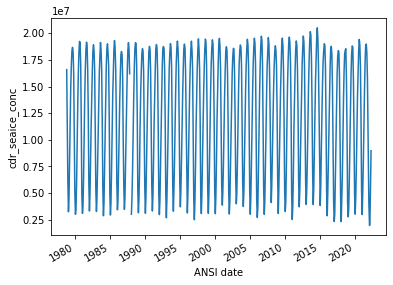

In [35]:
ant_conc.calc_extent()
ant_conc.extent_da.plot(); #plot for sanity

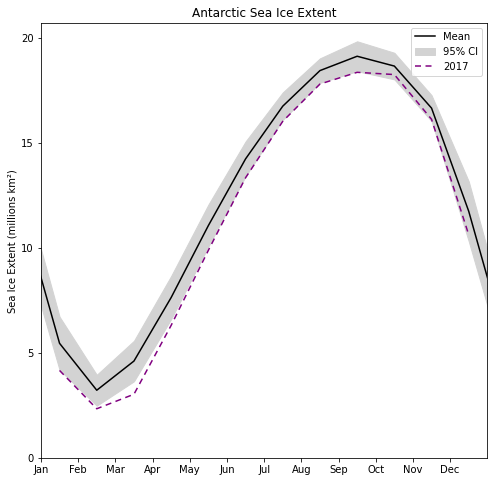

In [45]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, 2022)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')
plt.legend()
plt.show()

In [38]:
ant_conc.calc_area()

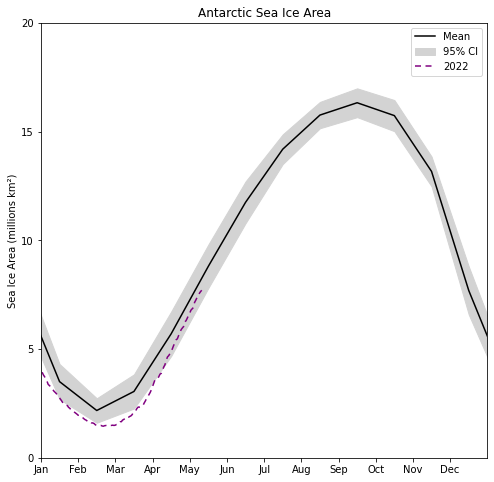

In [46]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(ant_conc.area_climat_ds)

plot_year(ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.title('Antarctic Sea Ice Area')
plt.show()

# distribution of sea ice

Monthly mean concentrations (1981-2010)

In [48]:
ant_conc.calc_gridded_anoms()

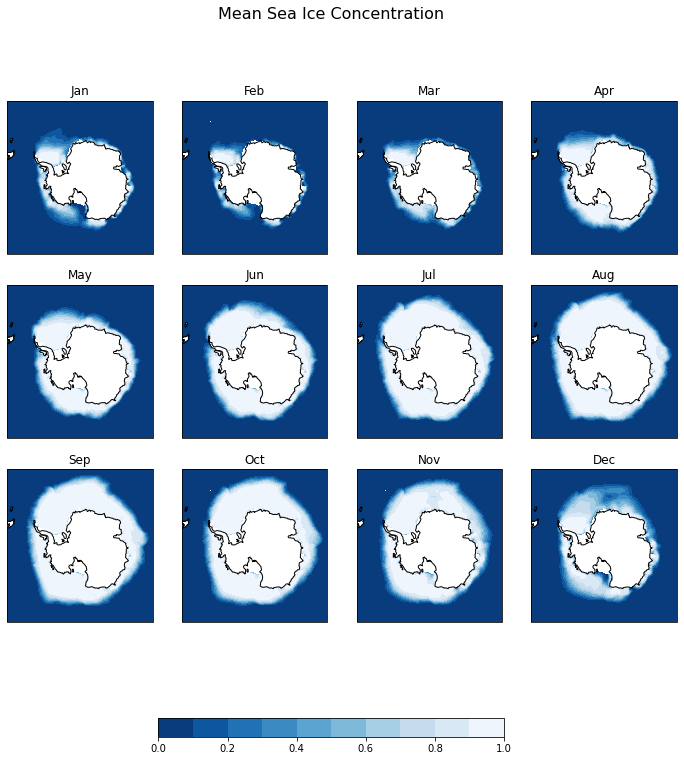

In [21]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# anomalies in distribution of sea ice

In [79]:
# reduce resolution to speed up contour lines?

coarse_anoms_da=ant_conc.anoms_da.coarsen(x=4).mean().coarsen(y=4).mean()

course_climat_ds=ant_conc.conc_climat_ds.coarsen(x=4).mean().coarsen(y=4).mean()

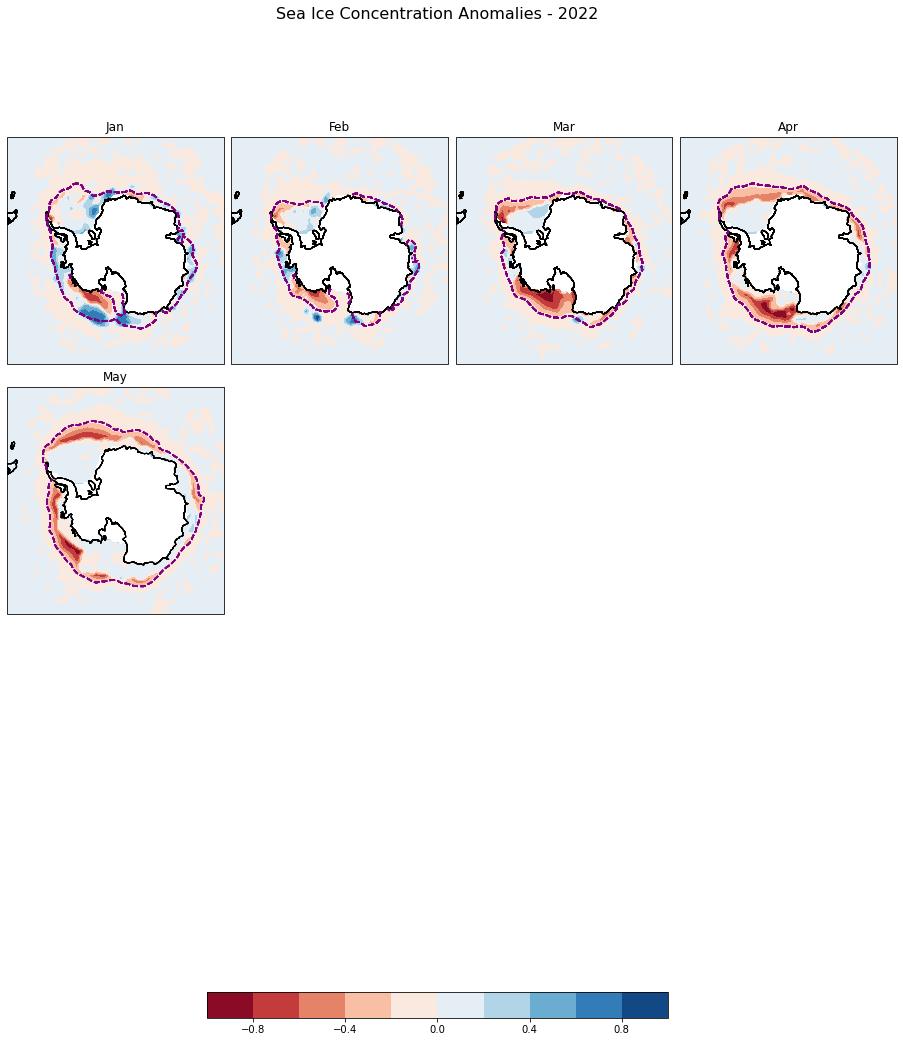

In [80]:
#very messy months in current year
months_in_current_year=ant_conc.anoms_da.where(ant_conc.anoms_da.time.dt.year==YEAR, drop=True).time.dt.month.values 

plt.figure(figsize=(16,18))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize=16)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=course_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=1.5,
        linestyles='dashed'
    )
    
    toPlot=coarse_anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.1,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# Repeat for east Antarctic only

In [23]:
EAST_ANT_LONS

[71, 160]

In [25]:
e_ant_conc=sea_ice_conc_monthly(
    cdr_xr.where(
        (cdr_xr.longitude>EAST_ANT_LONS[0])
        *(cdr_xr.longitude<EAST_ANT_LONS[1])
    ).cdr_seaice_conc, 
    areasKmNd
)

In [26]:
e_ant_conc.calc_extent()

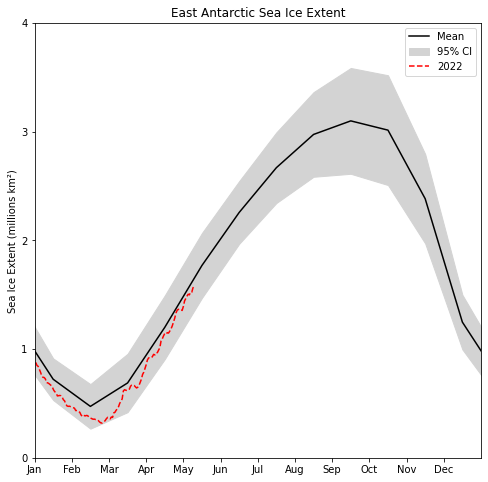

In [27]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(e_ant_conc.extent_climat_ds)

plot_year(e_ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.show()

In [28]:
e_ant_conc.calc_area()

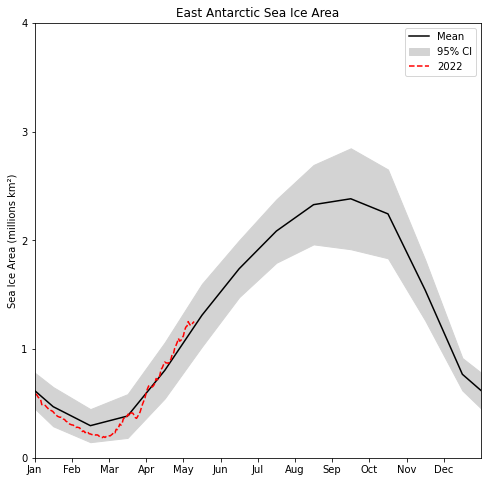

In [29]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat(e_ant_conc.area_climat_ds)

plot_year(e_ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.show()

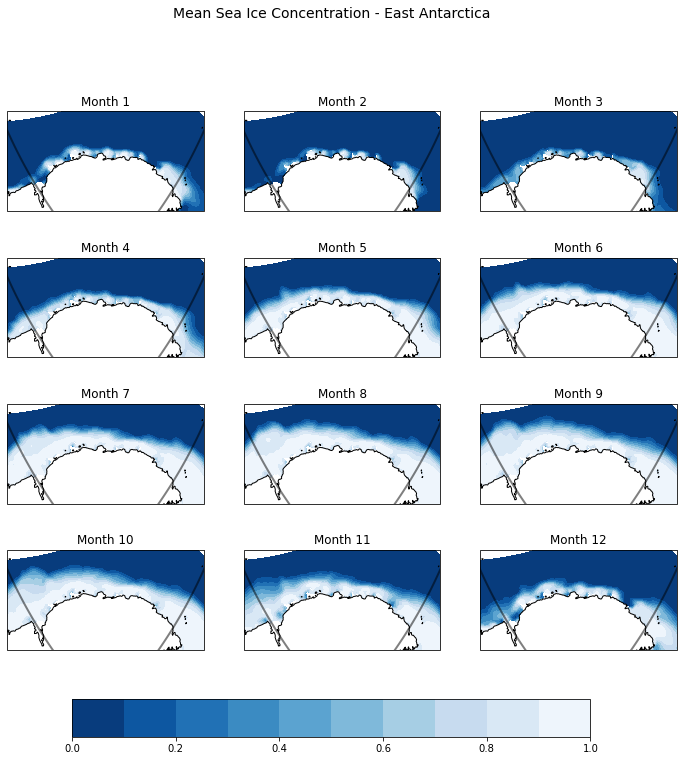

In [31]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration - East Antarctica', fontsize=14)


for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(
        5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

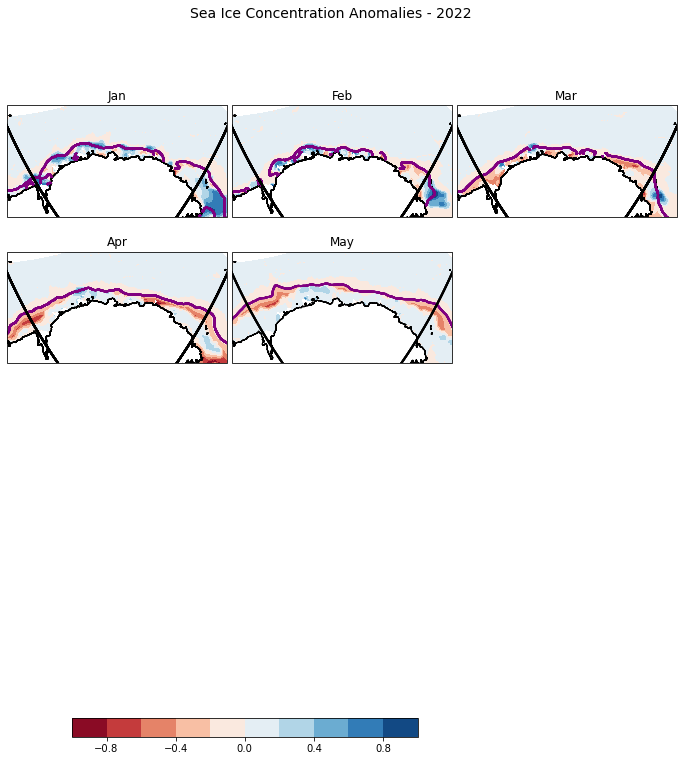

In [32]:
#very messy months in current year
months_in_current_year=ant_conc.anoms_da.where(ant_conc.anoms_da.time.dt.year==YEAR, drop=True).time.dt.month.values 

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize = 14)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=ant_conc.anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

# Min / max extents in East Antarctica

In [33]:
min_extents=e_ant_conc.extent_da.groupby('time.year').min()
max_extents=e_ant_conc.extent_da.groupby('time.year').max()

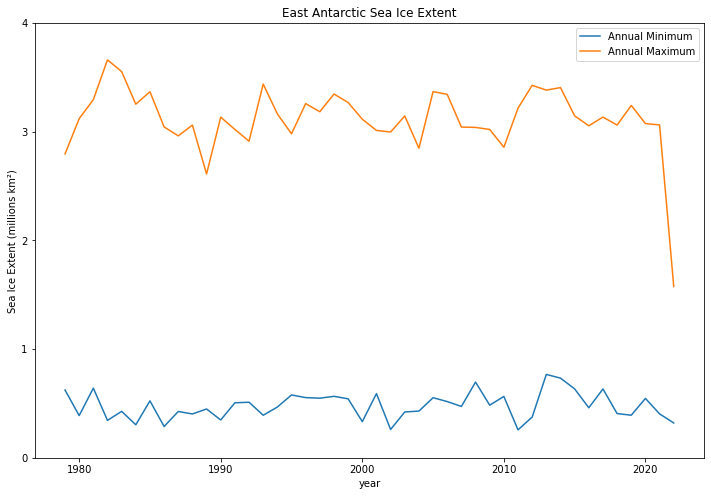

In [34]:
plt.figure(figsize=(12,8))

min_extents[1:].plot(label='Annual Minimum') #don't plot the first year (partial)
max_extents[1:].plot(label='Annual Maximum') 

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')
plt.legend()

plt.show()

This figure is probably not interesting. Repeats the earlier monthly figures and their is no trend (well established).

# And using the Uni Bremen ARTIST Data

This section is to show we can do it - this dataset only starts in 2012, so we are probably mostly interested in current conditions

In [7]:
import os
import pandas as pd

def paths_to_datetimeindex(paths, string_slice=(0, 10)):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format='%Y%m')

In [7]:
artist_monthly_xr=xr.open_dataset('/g/data/jk72/as2285/miz/data/artist_monthly.nc')

# East Antartic High Res Sea Ice Concentration

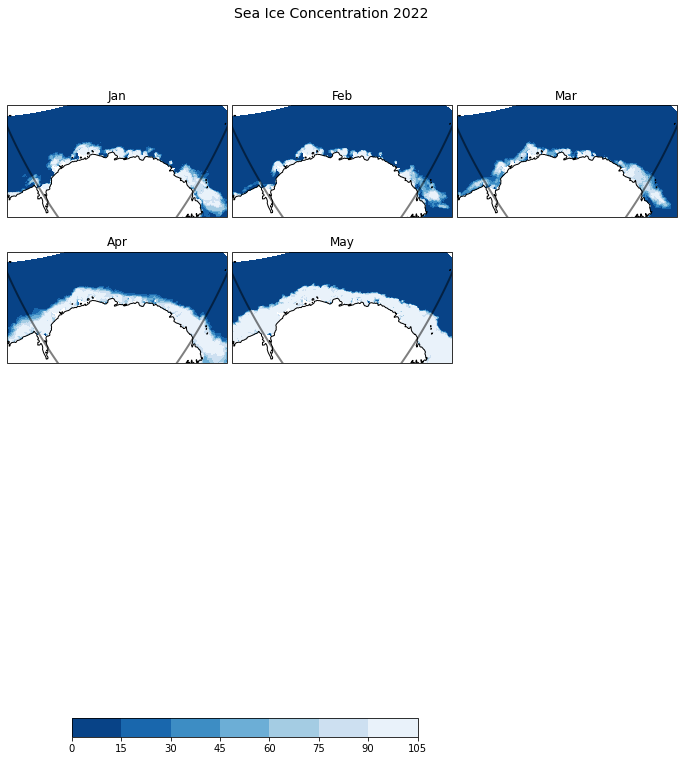

In [9]:
#very messy months in current year
months_in_current_year=artist_monthly_xr.z.where(
    artist_monthly_xr.z.time.dt.year==YEAR, drop=True
).time.dt.month.values 

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration ' + str(YEAR), fontsize = 14)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    toPlot=artist_monthly_xr.z.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        #levels=[0.2,0.4,0.6,0.8,0.9,1.00],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

In [8]:
artist_areas_xr=xr.open_dataarray('/g/data/jk72/MIZ/Bremen/PolStereo_GridCellArea_s6.25km_Antarctic.nc')

In [9]:
artist_ant_conc=sea_ice_conc_monthly(
    artist_monthly_xr.z, 
    artist_areas_xr, 
    climat_dates=[2012,2020],
    conc_range=[15,100]
)

In [10]:
artist_ant_conc.calc_gridded_anoms()

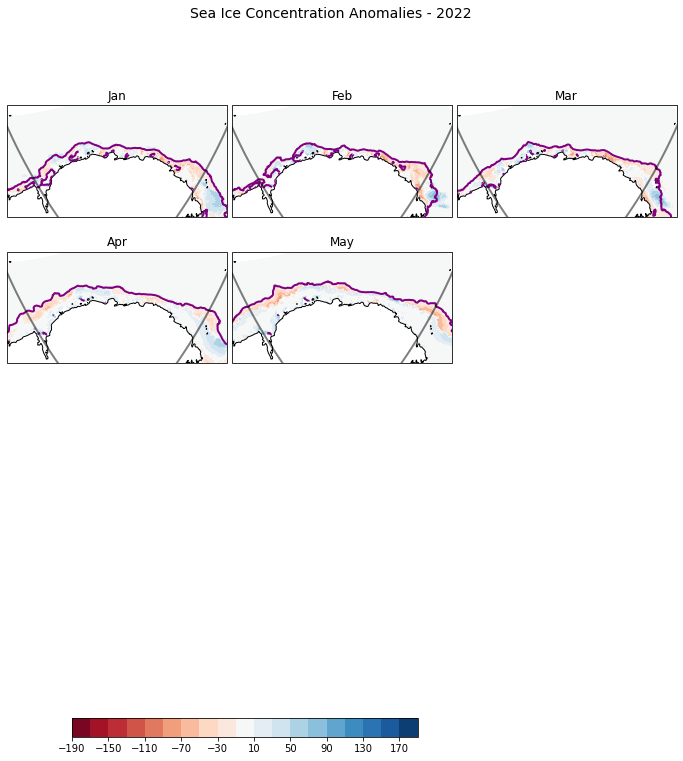

In [11]:
#very messy months in current year
months_in_current_year=artist_ant_conc.anoms_da.where(artist_ant_conc.anoms_da.time.dt.year==YEAR, drop=True).time.dt.month.values 

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize = 14)

for iMonth in months_in_current_year:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=artist_ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=[15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=artist_ant_conc.anoms_da.sel(time=np.datetime64(str(YEAR)+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=np.arange(-190,210,20),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[iMonth-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

Whats missing:

- validation

- length of advance/duration/retreat ( do the sector - number of days)

- merge monthly data with Seans version 

- Move file downloads to batch script?

- Save anoms to files to show in tracker? (and move to py file run daily?)